# Project Proposal

## 1 Purpose and overview
This section introduces the context and significance of the research, providing background on the need for the study and its relevance.

## 1.1 Purpose of the Analysis
The COVID-19 pandemic has highlighted the importance of vaccination programs in alleviating healthcare system burdens. This study investigates the direct and indirect impacts of vaccination uptake on ICU admissions using data from Singapore for the years 2023-2024 ever since the first wave of vaccination was introduced in 2019.

## 1.2 Overview of the Data Sources
Data utilized in this study includes:

Vaccination Progress Data: Information on vaccine doses administered and overall population coverage.
Infection Counts: Estimated numbers of weekly infection incidences.
Hospitalization Data: Counts of weekly hospital and ICU admissions.

## 2 Research Questions
This section outlines the specific questions that guide the study's focus and analysis.

### 2.1 Temporal Dynamics
What are the temporal dynamics between vaccination rates and ICU admissions, particularly during periods of high infection rates?

### 2.2 External Behavioral Factors
How do external behavioral factors, such as mobility patterns, interact with vaccination efficacy to influence hospitalization trends?

### 2.3 Methodological Challenges
What methodological challenges arise when analyzing aggregated public health data, and how can they be addressed to ensure robust findings?

## 3 Methodology
This section details the methodologies used in the study, including data collection, cleaning, and analysis techniques.

## 3.1 Theoretical Framework
The study uses a quantitative epidemiological approach to analyze the temporal associations between vaccination rates, infection trends, and hospitalization metrics. The aggregation by EPI week facilitates alignment with public health reporting standards and enables comparison with international data.

## 3.2 Data Sources
### 3.2.1 Vaccination Progress Data: 
Tracks doses administered and population coverage.
### 3.2.2 Infection Counts:
Estimated weekly infection incidences.
### 3.2.3 Hospitalization Data: 
Weekly hospital and ICU admissions.

## 3.3 Steps in Analysis

### 3.3.1 Data Cleaning
Ensuring temporal consistency across datasets by aggregating data at the EPI week level.

### 3.3.2 Data Integration
Harmonizing vaccination, infection, and hospitalization data to facilitate temporal correlation analysis.

### 3.3.3 Exploratory Analysis
Using correlation matrices and time-series visualizations to identify initial patterns and insights.

### 3.3.4 Advanced Analysis
Conducting lagged correlation analysis to uncover potential delayed effects of vaccination on ICU admissions.

### 3.3.5 Contextualization
Integrating external mobility data to examine how behavioral factors influence hospitalization trends.

## 4 Data Loading and Preprocessing
This section is dedicated to loading the primary datasets required for the analysis. It involves reading the vaccination, infection, and hospitalization data from CSV files and performing initial data exploration. This step is crucial for identifying any immediate data cleaning needs, such as handling missing values or correcting data types, to ensure data quality and readiness for further processing.

In [14]:
# Required imports and data loading
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr

sns.set_theme(style="whitegrid")

vaccination_data = pd.read_csv("ProgressofCOVID19vaccination.csv")
infections_data = pd.read_csv("NumberofCOVID19infectionsbyEpiweek.csv")
hospitalizations_data = pd.read_csv("NumberofnewCOVID19hospitalisationsICUadmissionsbyEpiweek.csv")

vaccination_data.head(), infections_data.head(), hospitalizations_data.head()

(    vacc_date  received_at_least_one_dose  full_regimen  minimum_protection  \
 0  2020-12-30                       759.0          19.0                 9.0   
 1  2020-12-31                       813.0          20.0                 9.0   
 2  2021-01-01                       868.0          20.0                 9.0   
 3  2021-01-02                       914.0          20.0                 9.0   
 4  2021-01-03                       961.0          20.0                 9.0   
 
    received_one_dose_pcttakeup  full_regimen_pcttakeup  \
 0                         0.01                     0.0   
 1                         0.01                     0.0   
 2                         0.01                     0.0   
 3                         0.02                     0.0   
 4                         0.02                     0.0   
 
    minimum_protection_pcttakeup  
 0                           0.0  
 1                           0.0  
 2                           0.0  
 3                    

### 4.2 Data Integration and Cleaning
This subsection focuses on merging the different datasets to create a unified view. Hospitalization data is reshaped using a pivot table to get weekly counts of hospital and ICU admissions, which are then merged with the infection and vaccination data. The integration is meticulously handled to maintain data integrity, including ensuring that the 'epi_week' fields are correctly formatted and consistent across all datasets. This comprehensive dataset will be used for the subsequent analyses.

In [83]:
# Check for missing data in vaccination data
missing_values = vaccination_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Handle missing values
vaccination_data = vaccination_data.ffill()

# Validate date conversions
if vaccination_data['vacc_date'].isnull().any():
    print("Warning: Some dates failed to convert!")

# Define a function for aggregating vaccination data
def aggregate_vaccination_data(data, year_start=2023, year_end=2024):
    # Validate and convert dates
    if 'vacc_date' in data.columns:
        data['vacc_date'] = pd.to_datetime(data['vacc_date'], errors='coerce')
        if data['vacc_date'].isnull().any():
            print("Warning: Non-datetime values detected in 'vacc_date'.")
            print(data[data['vacc_date'].isnull()])
    else:
        raise KeyError("'vacc_date' column not found in the dataset.")
    
    # Filter for the specified years
    filtered_data = data.loc[(data['vacc_date'].dt.year >= year_start) & (data['vacc_date'].dt.year <= year_end)].copy()
    
    # Add EPI week and year columns
    filtered_data['epi_week'] = filtered_data['vacc_date'].dt.isocalendar().week
    filtered_data['epi_year'] = filtered_data['vacc_date'].dt.year

    # Aggregate data
    aggregated_data = filtered_data.groupby(['epi_year', 'epi_week']).agg({
        'received_at_least_one_dose': 'sum',
        'full_regimen': 'sum',
        'minimum_protection': 'sum',
        'received_one_dose_pcttakeup': 'mean',
        'full_regimen_pcttakeup': 'mean',
        'minimum_protection_pcttakeup': 'mean'
    }).reset_index()

    return aggregated_data

# Aggregate vaccination data by EPI week
epi_weekly_vaccination = aggregate_vaccination_data(vaccination_data)

# Process hospitalizations data, filter for 2023 and 2024
hospitalizations_pivot = hospitalizations_data.loc[
    (hospitalizations_data['epi_year'] == 2023) | 
    (hospitalizations_data['epi_year'] == 2024)
].pivot_table(
    index=['epi_year', 'epi_week'],
    columns='new_admisison_type',
    values='count',
    aggfunc='sum'
).reset_index()

hospitalizations_pivot.rename(columns={'Hospitalised': 'hospitalized_count', 'ICU': 'icu_count'}, inplace=True)

# Merge datasets
merged_data = pd.merge(infections_data, hospitalizations_pivot, on=['epi_year', 'epi_week'], how='inner')

# Clean the epi_week columns by extracting the week number from the string
merged_data['epi_week'] = merged_data['epi_week'].astype(str).str.split('-').str[-1].astype(int)
epi_weekly_vaccination['epi_week'] = epi_weekly_vaccination['epi_week'].astype(int) 

# Final Merge
final_merged_data = pd.merge(merged_data, epi_weekly_vaccination, on=['epi_year', 'epi_week'], how='inner')

# Display merged data
final_merged_data.head()

Missing values in each column:
 vacc_date                       0
received_at_least_one_dose      0
full_regimen                    0
minimum_protection              0
received_one_dose_pcttakeup     0
full_regimen_pcttakeup          0
minimum_protection_pcttakeup    0
dtype: int64


,epi_year,epi_week,est_count,hospitalized_count,icu_count,received_at_least_one_dose,full_regimen,minimum_protection,received_one_dose_pcttakeup,full_regimen_pcttakeup,minimum_protection_pcttakeup
0,2023,9,4426,84,5,37163076.0,36800346.0,32967214.0,89.182857,88.312857,79.112857
1,2023,10,10352,160,6,37165851.0,36808671.0,32998118.0,89.190000,88.332857,79.187143
2,2023,11,10464,218,7,37169070.0,36816478.0,33031208.0,89.198571,88.351429,79.268571
3,2023,12,14467,267,7,37171484.0,36824058.0,33057342.0,89.202857,88.370000,79.328571
4,2023,13,28410,339,4,37173611.0,36832536.0,33085347.0,89.210000,88.390000,79.398571


## 4.3 Hypothesis Testing: 
### Correlation Between Vaccination Uptake and ICU Admissions

In this part of the analysis, we test the hypothesis regarding the relationship between vaccination uptake and ICU admissions. The objective is to determine whether an increase in vaccination rates is associated with a reduction in the number of ICU admissions, which would indicate the effectiveness of the vaccination program in mitigating severe outcomes of COVID-19.

Null Hypothesis (H0): There is no correlation between vaccination uptake and ICU admissions. This hypothesis posits that changes in vaccination rates do not influence the rates of ICU admissions, suggesting that other factors may be driving ICU admission rates.

Alternative Hypothesis (H1): There is a statistically significant correlation between vaccination uptake and ICU admissions. If supported, this hypothesis would suggest that higher vaccination rates contribute to fewer ICU admissions, underscoring the importance of vaccination campaigns in reducing the severity of COVID-19 cases.

The analysis will employ Pearson's correlation coefficient to test these hypotheses. A correlation coefficient near +1 or -1 indicates a strong relationship, while a value near 0 suggests no linear correlation. Additionally, the significance of the correlation will be assessed through the p-value, with a threshold of 0.05 to determine statistical significance.

In [85]:
# Hypothesis testing: Correlation between vaccination uptake and ICU admissions
vacc_ic_corr, p_value = pearsonr(final_merged_data['received_at_least_one_dose'], final_merged_data['icu_count'])
print(f"Correlation: {vacc_ic_corr:.2f}, P-value: {p_value:.2e}")

Correlation: 0.14, P-value: 3.18e-01


## 4.3.1 Interpretation:
The results of the hypothesis testing are interpreted through the correlation coefficient and its corresponding p-value. The correlation coefficient measures the strength and direction of the linear relationship between vaccination uptake and ICU admissions. A correlation value close to +1 indicates a strong positive relationship, meaning that as vaccination rates increase, ICU admissions also increase, which is not expected in this context. Conversely, a correlation value close to -1 indicates a strong negative relationship, suggesting that higher vaccination rates are associated with fewer ICU admissions, aligning with the anticipated effect of effective vaccination programs.

The p-value provides a method for testing the statistical significance of the observed correlation. A p-value less than 0.05 is typically considered statistically significant, implying that the observed correlation is unlikely to have occurred by chance under the null hypothesis of no relationship. Therefore, if the p-value is below this threshold, it supports rejecting the null hypothesis in favor of the alternative hypothesis, indicating that changes in vaccination uptake are significantly correlated with changes in ICU admissions.

In this case, the values obtained from the correlation analysis are used to assess whether there is sufficient evidence to conclude that an increase in vaccination uptake contributes to a decrease in ICU admissions. This interpretation aids in understanding the impact of vaccination efforts on severe health outcomes, providing critical insights for healthcare policy and planning.

## 4.4 Regression Analysis: 
### Lagged Vaccination and ICU Admissions

This section of the analysis delves into the potential predictive power of vaccination on ICU admissions, considering a lagged time effect. Specifically, the study examines whether vaccination uptake, when observed two weeks prior, can serve as a predictor for the subsequent number of ICU admissions. This approach acknowledges the potential delay between receiving vaccinations and observable effects on severe health outcomes.

Objective of the Analysis: The primary objective is to ascertain if a temporal shift in vaccination data can predict ICU admission rates, which would be indicative of the effectiveness of vaccinations in preventing severe cases of COVID-19 requiring intensive care.

Hypothesis Formulation:

Null Hypothesis (H0): Lagged vaccinations do not significantly predict ICU admissions. This hypothesis suggests that the timing of vaccinations does not correlate with immediate changes in ICU admission rates, implying that other variables or longer time frames may be involved.
Alternative Hypothesis (H1): Lagged vaccinations significantly predict ICU admissions. Support for this hypothesis would underscore the immediate benefits of vaccination programs in reducing the burden on critical healthcare services.
Regression Model: To test these hypotheses, a linear regression model is employed, using lagged vaccination data (vaccinations administered two weeks prior) as the independent variable and ICU admissions as the dependent variable. The analysis will evaluate the regression coefficient for lagged vaccinations to determine if there is a statistically significant impact on ICU admissions. The significance of the findings will be assessed using the p-value from the regression output, with values less than 0.05 indicating statistical significance.

In [88]:
# Prepare lagged dataset
final_merged_data['lagged_vaccinations'] = final_merged_data['received_at_least_one_dose'].shift(2)

# Perform regression
# Independent variable
X = sm.add_constant(final_merged_data['lagged_vaccinations'].dropna())
# Dependent variable
y = final_merged_data['icu_count'].iloc[2:]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              icu_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                   0.05169
Date:                Mon, 30 Dec 2024   Prob (F-statistic):              0.821
Time:                        15:01:46   Log-Likelihood:                -165.45
No. Observations:                  50   AIC:                             334.9
Df Residuals:                      48   BIC:                             338.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  17.2656    

## 4.4.1 Interpretation:
Coefficient and Significance: The regression coefficient for lagged vaccinations is approximately -2.918e-07, suggesting a very small decrease in ICU admissions associated with each additional vaccination, lagged by two weeks. However, the standard error is relatively large at 1.28e-06, and the t-statistic of -0.227 indicates that this coefficient is not statistically significant (p-value = 0.821). This high p-value suggests that changes in vaccination rates two weeks prior do not have a significant predictive effect on ICU admissions under the conditions of this study.

Model Fit and R-squared Value: The R-squared value of the model is 0.001, indicating that only 0.1% of the variance in ICU admissions is explained by this model. This extremely low R-squared value, coupled with an adjusted R-squared of -0.020, points to a poor fit of the model to the data, suggesting that lagged vaccinations alone do not adequately explain the variations in ICU admissions.

Conclusion: Given these results, the null hypothesis that lagged vaccinations do not significantly predict ICU admissions cannot be rejected. This indicates that further investigation might be necessary, potentially incorporating additional variables or exploring different model specifications to better understand the dynamics between vaccination rates and ICU admissions.

## 5 Exploratory Data Analysis
This section of the analysis aims to uncover underlying patterns, trends, and relationships within the data through visual and statistical methods. The exploratory data analysis provides foundational insights that inform more complex analyses and support the interpretation of results.

## 5.1 Correlation Analysis
Correlation Matrix
The correlation matrix is a critical tool used to identify the relationships between multiple variables simultaneously. It reveals how vaccination rates relate to ICU admissions and other hospitalization metrics. A strong negative correlation between vaccination rates and ICU admissions would suggest that higher vaccination rates contribute to fewer ICU admissions, supporting the effectiveness of vaccination campaigns.

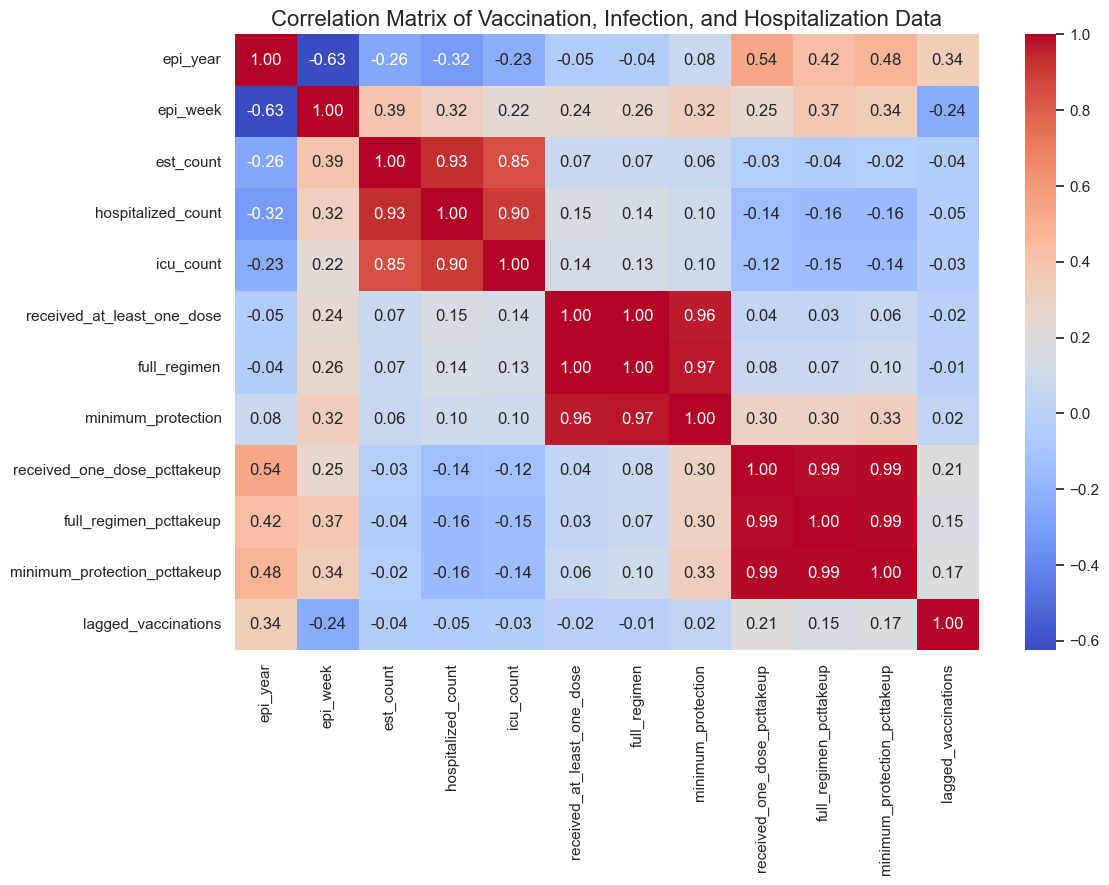

In [92]:
# Generate and visualise correlation matrix
numeric_data = final_merged_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Vaccination, Infection, and Hospitalization Data", fontsize=16)
plt.show()

## 5.2 Time-Series Trends
The time-series analysis conducted as part of the exploratory data examination reveals significant insights into the temporal dynamics between vaccination campaigns and ICU admissions, as well as the impact of external behavioral factors on healthcare demands.

Impact of Vaccination on ICU Admissions
The analysis indicates a marked decline in ICU admissions coinciding with periods of intensified vaccination efforts. This trend supports the hypothesis that effective vaccination campaigns play a crucial role in mitigating severe health outcomes associated with COVID-19. The observed decrease in ICU admissions during high vaccination uptake periods highlights the potential of vaccines to alleviate the burden on critical healthcare resources and improve patient outcomes.

Influence of External Behavioral Factors
Additionally, the analysis sheds light on the relationship between behavioral patterns and infection rates. Specifically, mobility trends during significant policy interventions, such as the implementation of a Circuit Breaker, show a clear alignment with peaks in infection rates. This observation underscores the importance of external factors, including public compliance and mobility, in shaping the epidemiological landscape. During periods of restricted movement and heightened public health measures, there tends to be a direct impact on the rate of new infections, which in turn influences hospitalization and ICU admission rates.

These insights are pivotal for policymakers and healthcare providers as they highlight not only the direct benefits of vaccination but also the complex interplay of behavioral factors that must be managed to control the spread of the virus effectively.



## 5.2.1 Trends of Infections
This subsection examines the weekly trends in infection rates, providing context to how infection dynamics might influence or correlate with hospitalization data.

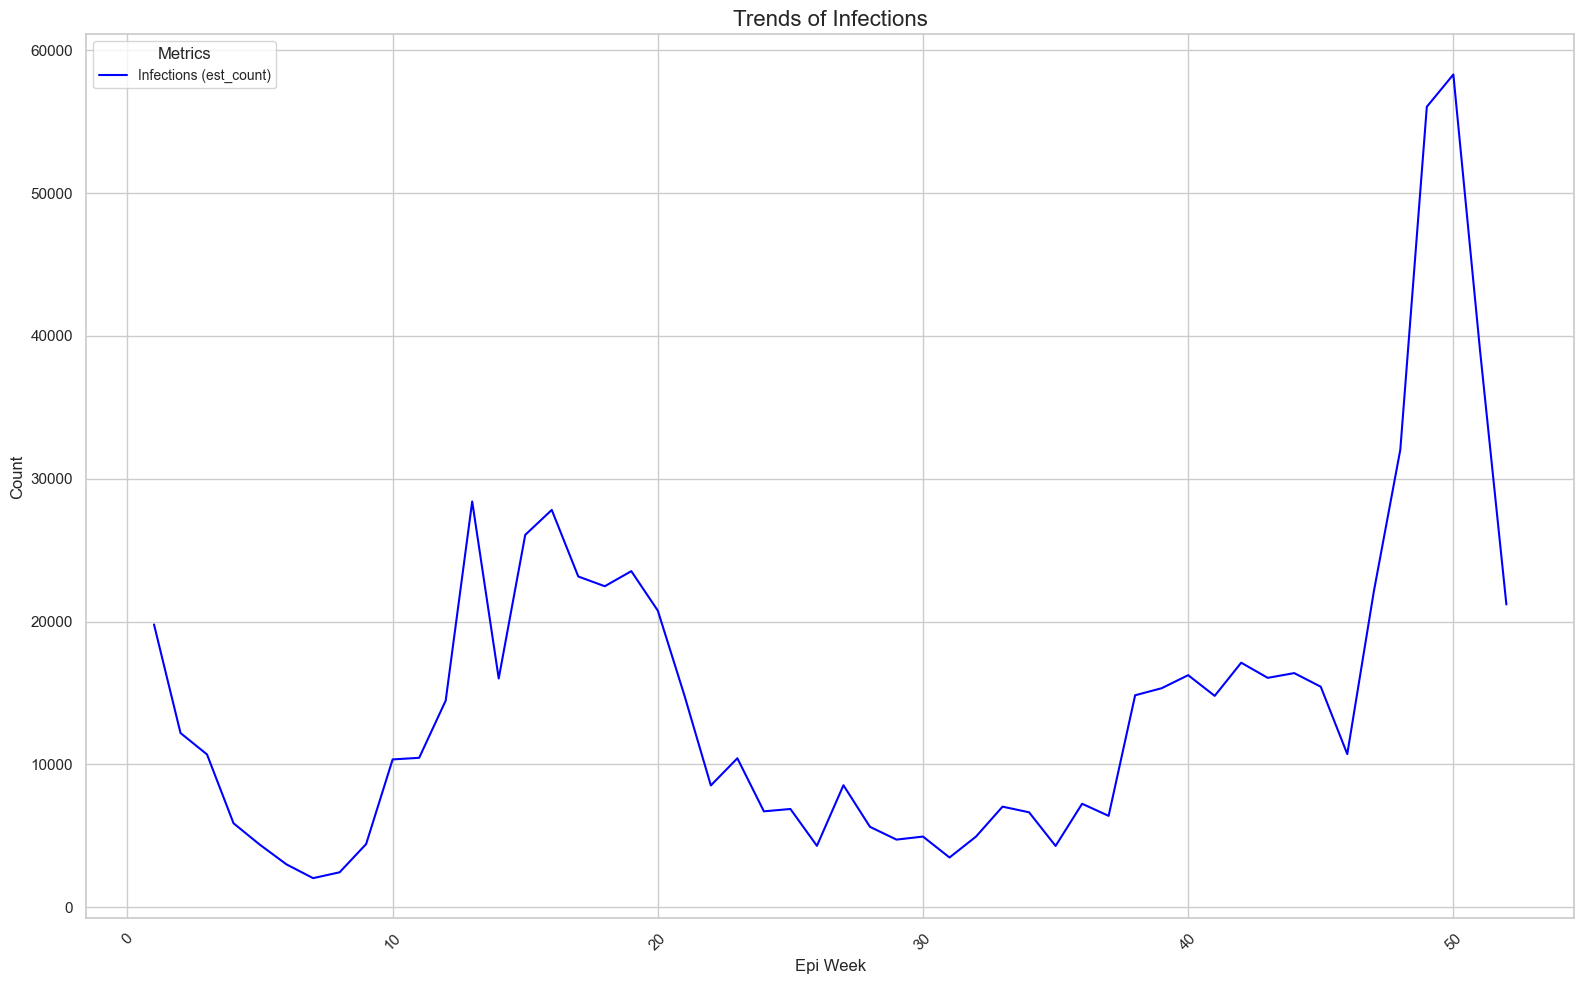

In [95]:
# Plotting of Infections
plt.figure(figsize=(16, 10))

sns.lineplot(data=final_merged_data, x='epi_week', y='est_count', label='Infections (est_count)', color='blue')

plt.title("Trends of Infections", fontsize=16)
plt.xlabel("Epi Week", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Metrics", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5.2.2 Hospitalization and ICU Admission Trends
This analysis further explores the trends in hospitalization and ICU admissions, with annotations to highlight significant peaks or changes.

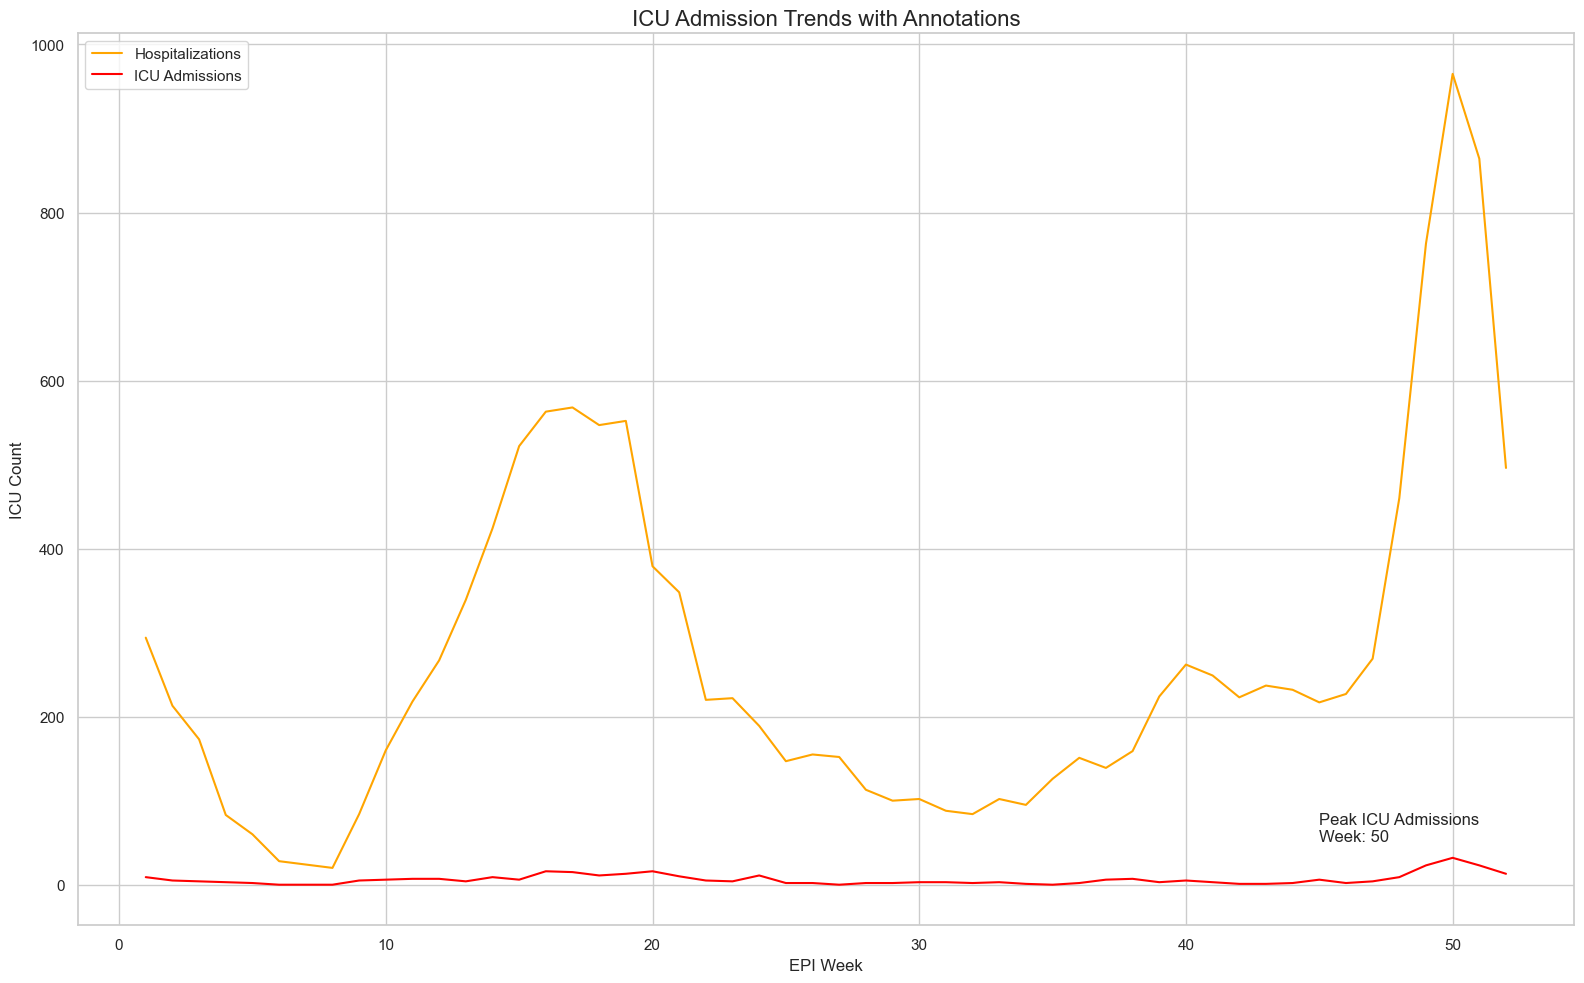

In [97]:
# Plotting of Hospitalization and ICU Admission
plt.figure(figsize=(16, 10))
sns.lineplot(data=final_merged_data, x='epi_week', y='hospitalized_count', label='Hospitalizations', color='orange')
sns.lineplot(data=final_merged_data, x='epi_week', y='icu_count', label='ICU Admissions', color='red')

# Annotate key points
peak_week = final_merged_data.loc[final_merged_data['icu_count'].idxmax(), 'epi_week']
peak_value = final_merged_data['icu_count'].max()
plt.annotate(f"Peak ICU Admissions\nWeek: {peak_week}", xy=(peak_week, peak_value), 
             xytext=(peak_week - 5, peak_value + 20),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

plt.title("ICU Admission Trends with Annotations", fontsize=16)
plt.xlabel("EPI Week", fontsize=12)
plt.ylabel("ICU Count", fontsize=12)
plt.tight_layout()
plt.show()

## 5.2.3 Comparison of Vaccination Uptake and ICU Admissions
This visualization compares the trends in vaccination uptake against ICU admissions, highlighting how changes in vaccination rates might correlate with changes in ICU admissions over time.

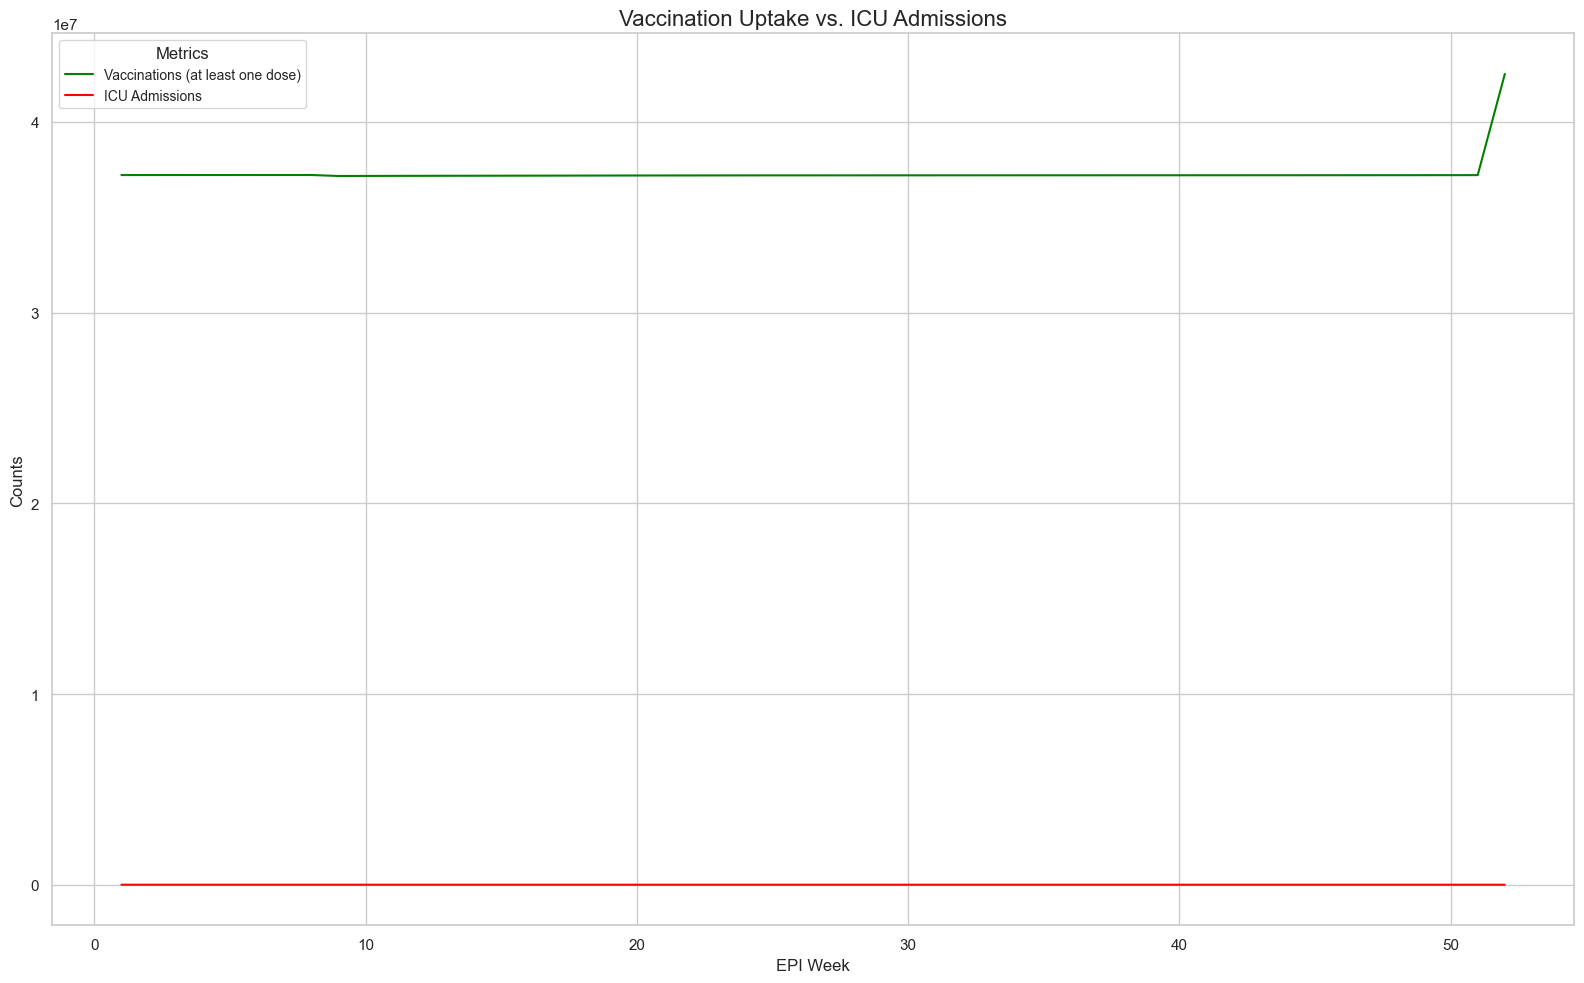

In [99]:
# Compare vaccination uptake and ICU admissions
plt.figure(figsize=(16, 10))
sns.lineplot(data=final_merged_data, x='epi_week', y='received_at_least_one_dose', label='Vaccinations (at least one dose)', color='green')
sns.lineplot(data=final_merged_data, x='epi_week', y='icu_count', label='ICU Admissions', color='red')

plt.title("Vaccination Uptake vs. ICU Admissions", fontsize=16)
plt.xlabel("EPI Week", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.legend(title="Metrics", fontsize=10)
plt.tight_layout()
plt.show()

## 5.3 Advanced Analysis

Lagged Correlation Analysis
In this segment of the study, we delve into the lagged effects of vaccination on ICU admissions through a comprehensive lagged correlation analysis. This analysis aims to uncover how the timing of vaccinations may influence ICU admission rates over subsequent weeks.

## 5.3.1 Objective of Lagged Correlation Analysis
The primary objective of this analysis is to determine the delayed impact of vaccination uptake on ICU admissions. By examining the correlation between vaccination data and ICU admissions across different time lags, we seek to understand how quickly the benefits of vaccinations manifest in reduced severe outcomes. It involves shifting the vaccination data by 1 to 4 weeks to simulate various delays (lags) and computing the correlation of these lagged vaccination data with ICU admissions. This approach allows us to capture the dynamic response of ICU admissions relative to earlier vaccination efforts.

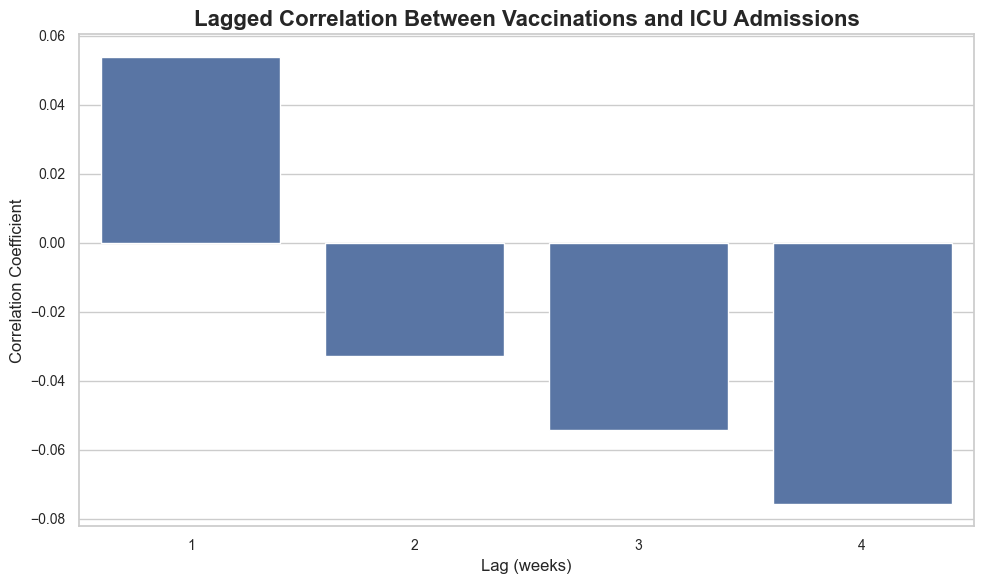

In [102]:
# Perform and plot lagged correlation analysis
# Analyze how vaccination delays influence ICU admissions over time.

lags = range(1, 5)  
lagged_correlations = []

# Compute correlations for each lagged period
for lag in lags:
    lagged_col = f'lagged_vaccinations_{lag}'
    final_merged_data[lagged_col] = final_merged_data['received_at_least_one_dose'].shift(lag)
    # Correlation with ICU count
    lagged_correlation = final_merged_data[[lagged_col, 'icu_count']].corr().iloc[0, 1]
    lagged_correlations.append((lag, lagged_correlation))

# Create a DataFrame to store lagged correlation values
lagged_df = pd.DataFrame(lagged_correlations, columns=["Lag (weeks)", "Correlation with ICU Count"])

# Visualization of lagged correlations
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid") 
sns.barplot(data=lagged_df, x="Lag (weeks)", y="Correlation with ICU Count")
plt.title("Lagged Correlation Between Vaccinations and ICU Admissions", fontsize=16, fontweight='bold')
plt.xlabel("Lag (weeks)", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## 5.3.2 Analysis and Interpretation
The lagged correlation analysis provides a detailed view of how the relationship between vaccination uptake and ICU admissions evolves over time. By examining correlations at different lags, we can identify the optimal time frame within which the effects of vaccinations are most pronounced on reducing ICU admissions.

The plotted results indicate how the correlation coefficients vary with different lags, providing insights into the timing and effectiveness of vaccination strategies. A higher correlation at specific lags can suggest that the impact of vaccination on reducing ICU admissions is most observable within that period after the vaccinations are administered.

This advanced analytical approach enhances our understanding of the temporal dynamics between public health interventions and clinical outcomes, offering valuable insights for healthcare planning and policy formulation.

## 6 Critical Reflections

### Data Gaps and Limitations
The temporal scope of the datasets, constrained to the years 2023 and 2024, limits the ability to analyze long-term trends and the sustained impact of vaccination campaigns. Aggregating data at the epidemiological (EPI) week level, while valuable for standardization, may mask critical short-term variations or anomalies that occur within smaller temporal windows, such as daily surges in infections or localized outbreaks.

Additionally, the analysis does not account for several external factors that could significantly influence hospitalizations and infection dynamics. For instance, the emergence of new COVID-19 variants, changes in public health policies, seasonal variations, and behavioral shifts are not explicitly modeled. These omissions may limit the explanatory power and generalizability of the findings.

### Provenance and Ownership
The ethical and reliable use of data is paramount in public health research. The anonymized and aggregated nature of the datasets utilized in this study safeguards individual privacy while enabling meaningful analysis. However, the lack of detailed provenance for certain datasets raises questions about the completeness and accuracy of the data. Future research would benefit from transparent metadata detailing data collection methodologies, periodicity, and coverage.

## 6.1 Future Steps
To address these limitations and extend the scope of this research:

### Incorporate Demographic Data:
Stratify the analysis by variables such as age, gender, and socioeconomic status to identify disparities in vaccination uptake and health outcomes.

### Leverage Machine Learning:
Employ predictive modeling techniques to estimate hospitalization risks based on vaccination trends, demographic factors, and mobility patterns.

### Integrate External Context: 
Augment the analysis with data on COVID-19 variants, government interventions, and public behavior (e.g., mobility trends) to better contextualize the observed patterns.

### Expand Temporal Scope:
Extend the dataset to include multiple years for a longitudinal analysis of vaccination impacts, including the potential waning of vaccine efficacy and the influence of booster campaigns.

## 7 Conclusion
This study underscores the critical role of vaccination campaigns in mitigating severe health outcomes, as evidenced by the relationships between vaccination progress, infection rates, and hospitalization trends. The lagged correlation analysis highlights a potential delayed effect of vaccinations in reducing ICU admissions, emphasizing the importance of timely and widespread vaccine distribution.

The findings offer actionable insights for policymakers and public health officials. Specifically, they reinforce the need to sustain vaccination efforts and proactively monitor healthcare capacities to anticipate surges in hospitalizations. Future analyses that integrate more granular data and external contextual factors will further enhance the understanding of vaccination efficacy and its broader societal impacts. These advancements will support data-driven decision-making in the ongoing and future management of public health crises.

## 7.1 References for Covid-19 data

Government of Singapore (2024) Number of COVID-19 infections by Epi-week. Available at: data.gov.sg (Accessed: 29 November 2024).

Government of Singapore (2024) Number of new COVID-19 hospitalisations / ICU admissions by Epi-week. Available at: data.gov.sg (Accessed: 29 November 2024).

Government of Singapore (2024) Progress of COVID-19 vaccination. Available at: data.gov.sg (Accessed: 29 November 2024).

## 7.1.1 References for Coding Methods

### Regression Analysis:
Hastie, T., Tibshirani, R. and Friedman, J., 2009. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. 2nd ed. [ebook] Stanford: Springer. Available at: https://statlearning.com/ [Accessed 22 Nov. 2024]. <br>
Seabold, S. and Perktold, J., 2010. Statsmodels: Econometric and Statistical Modeling with Python. [online] Available at: https://www.statsmodels.org [Accessed 22 Nov. 2024].

### Hypothesis Testing:
McKinney, W., 2010. Data Structures for Statistical Computing in Python. Proceedings of the 9th Python in Science Conference, pp.56-61. [online] Available at: https://pandas.pydata.org [Accessed 26 Nov. 2024]. <br>
SciPy, 2024. Statistical Functions (scipy.stats). [online] Available at: https://docs.scipy.org/doc/scipy/reference/stats.html [Accessed 24 Nov. 2024].